In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")   

sklearn version:  0.24.2
TF version:  2.6.2
No GPU was detected. CNNs can be very slow without a GPU.
GPU installed:  True


In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# file이 있는 path로 이동
os.chdir("./emnist")
# os.chdir('/content/drive/MyDrive/ANN/') 

In [4]:
# 현재 작업 경로 확인
path = os.getcwd()
print(path)

C:\ANN2022\project\emnist


In [5]:
# Load EMNIST dataset
import pandas as pd
# import gzip

byclass_train = pd.read_csv("./emnist-byclass-train.csv")
byclass_test = pd.read_csv("./emnist-byclass-test.csv")
mapp = pd.read_csv("./emnist-byclass-mapping.txt", 
                   delimiter = ' ', index_col=0, header=None, squeeze=True)

In [6]:
classes = len(byclass_train['35'].value_counts())
print('number of classes: ', classes)

number of classes:  62


In [7]:
byclass_train.head()

,35,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.466,0.467,0.468,0.469,0.470,0.471,0.472,0.473,0.474,0.475
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,38,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Train set TSNE

from sklearn.manifold import TSNE

image_tsne = TSNE(n_components=2).fit_transform(byclass_train)

C:\Anaconda3\envs\ANN\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


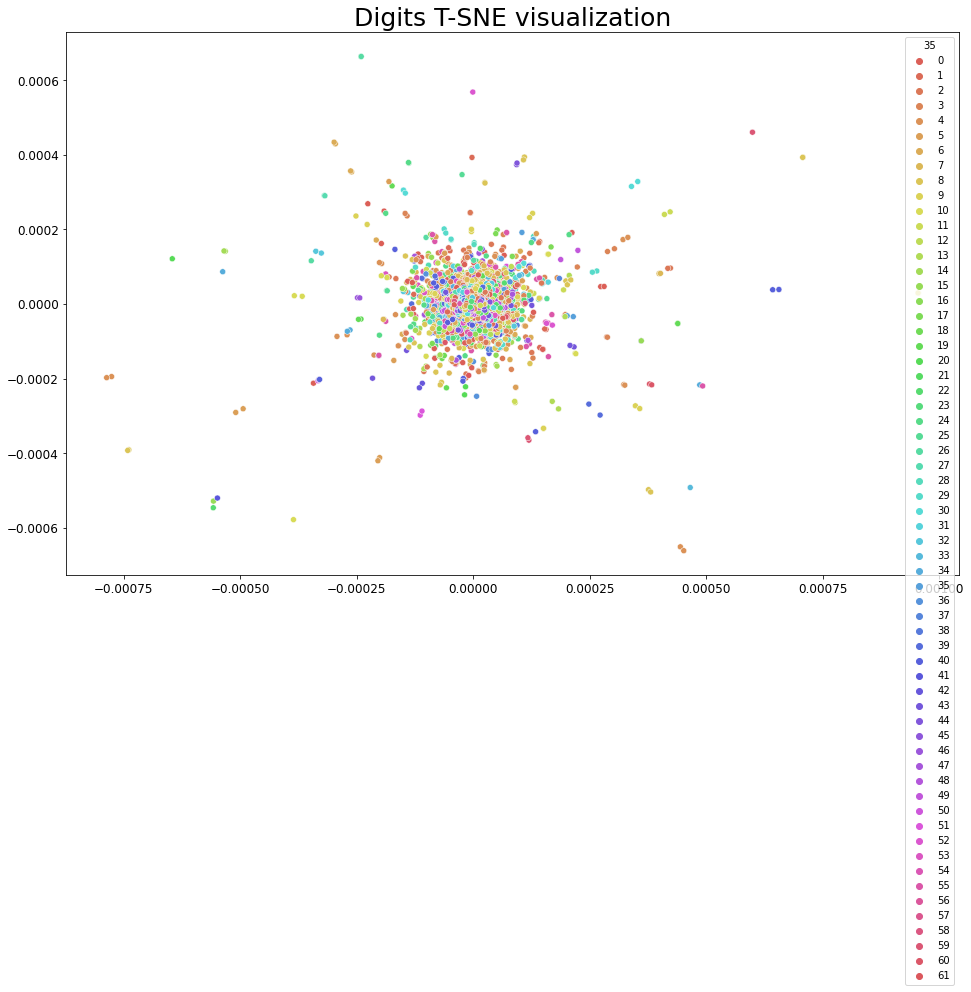

<Figure size 432x288 with 0 Axes>

In [9]:
import seaborn as sns

plt.figure(figsize=(16,10))
plt.title("Digits T-SNE visualization", fontsize=25)
sns.scatterplot(
    x=image_tsne[:,0], y=image_tsne[:,1],
    hue=byclass_train["35"],
    palette=sns.color_palette("hls", classes),
    legend="full"
)
plt.show()
plt.savefig('train_data_TSNE.png')

In [10]:
byclass_test.head()

,18,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Test set TSNE
image_tsne_test = TSNE(n_components=2).fit_transform(byclass_test)

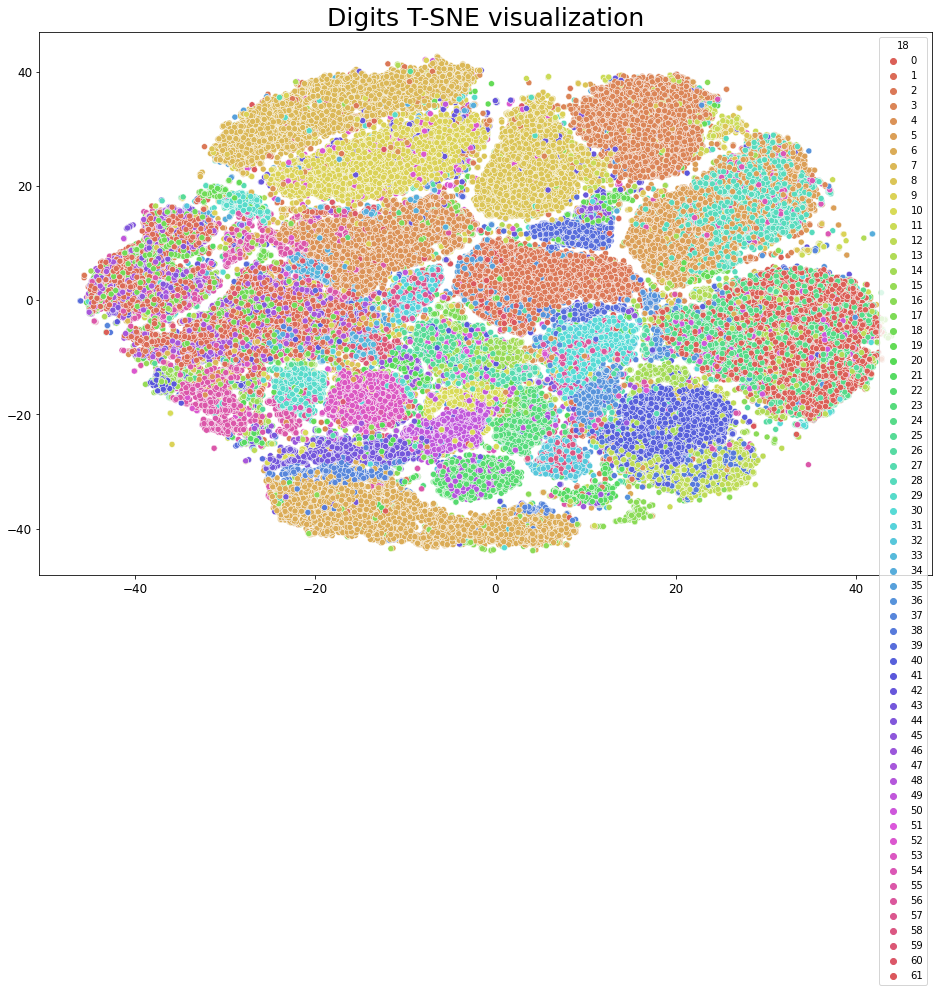

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(16,10))
plt.title("Digits T-SNE visualization", fontsize=25)
sns.scatterplot(
    x=image_tsne_test[:,0], y=image_tsne_test[:,1],
    hue=byclass_test["18"],
    palette=sns.color_palette("hls", classes),
    legend="full"
)
plt.show()
plt.savefig('test_data_TSNE.png')